# Classic timeseries models

The purpose of the naive models are to form a benchmark for performance. This allows us to compare the performance of feature engineering, hyperparameter tuning, and model architecture against a set of references.


### Test Harness: Walk forward validation
A test rig is a naive implementation of the prediction model. In this notebook univariate and multivariate rigs are deployed as benchmarks for improvement in predictions.

Naive univariate models are deployed using only the most recent data point in time to predict the next. I.e. t-1 = t. 

Multivariate models are deployed using all available feature vectors as predictors.  


#### Classic Prediction Models
- Naive Model
- Moving Averages
- ARIMA

In [11]:
#import required packages
import numpy as np
import pandas as pd
from tensorflow.keras import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('dark')

In [2]:
#load the preprocessed data
data = pd.read_csv('./data/processed/transformed_2016_2018.csv')

#investigate features for h_0
#y-hat is columns from t-0
data[['t-0 h_0','t-1 h_0']].head()

,t-0 h_0,t-1 h_0
0,25833.0,27662.0
1,22113.0,25833.0
2,26810.0,22113.0
3,27578.0,26810.0
4,26897.0,27578.0


#### Dataset creation

In [43]:
data.head()

,date,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,...,t-30 h_14,t-30 h_15,t-30 h_16,t-30 h_17,t-30 h_18,t-30 h_19,t-30 h_20,t-30 h_21,t-30 h_22,t-30 h_23
0,2016-01-31,25833.0,23820.0,22863.0,22056.0,21622.0,21588.0,21940.0,22543.0,23143.0,...,23265.0,22061.0,21481.0,21830.0,24291.0,25234.0,25881.0,26149.0,25610.0,24000.0
1,2016-02-01,22113.0,20515.0,19284.0,18637.0,18352.0,18574.0,19751.0,20857.0,22156.0,...,32099.0,31449.0,31179.0,31175.0,32515.0,34967.0,35381.0,34700.0,32055.0,28939.0
2,2016-02-02,26810.0,24903.0,23819.0,23418.0,23240.0,23890.0,26441.0,30975.0,33582.0,...,33029.0,32344.0,31927.0,31824.0,32226.0,35161.0,36599.0,35729.0,33154.0,29838.0
3,2016-02-03,27578.0,25540.0,24448.0,23929.0,23895.0,24570.0,27320.0,31510.0,34134.0,...,31594.0,30376.0,29915.0,29633.0,29158.0,29159.0,30469.0,32482.0,30508.0,28598.0
4,2016-02-04,26897.0,25029.0,23563.0,22858.0,22426.0,22230.0,22885.0,24204.0,25201.0,...,23378.0,22190.0,21549.0,21233.0,21298.0,21756.0,22929.0,25815.0,25843.0,24167.0


In [3]:
def set_X_Y_features(data, y_target='t-0', univariate=False):
    """
    Function that takes in the preprocessed data and returns the Y and X datasets for univariate and multivariate test harnesses.
    
    """
    
    #if univariate is called, the function returns the current time step, and the previous time step.
    if univariate:
        y_target='t-0'
        #select the column headers to build Y matrix
        Y_cols = [col for col in data.columns if y_target == col.split()[0]]
        
        x_targets = 't-1'
        #selects the columns headers to build feature vectors of X
        X_cols = [col for col in data.columns if x_targets == col.split()[0]]
    
    #if not univariate then X and Y return the multivariate case with all features
    else:
        #function is incomplete here. following two rows are wrong!!!
        Y_cols = [col for col in data.columns if y_target == col.split()[0]]
        
        X_cols = [col for col in data.columns if y_target == col.split()[0]]
        
    #convert dataframe into numpy array
    Y = np.array(data[Y_cols])
    
    X = np.array(data[X_cols])
    
    return X, Y

In [32]:
X_naive, Y_naive = set_X_Y_features(data, univariate=True)
X_naive.shape, Y_naive.shape

((1066, 24), (1066, 24))

#### Split test and train sets

In [5]:
def split_train_test(X, Y, size):
    """
    Function to split data into train and test sets.
    
    """
    
    train_size = int(len(X) * size)
    
    X_train, X_test = X[:train_size], X[train_size:]
    
    Y_train, Y_test = Y[:train_size], Y[train_size:]
    
    return X_train, X_test, Y_train, Y_test

In [33]:
X_train_naive, X_test_naive, Y_train_naive, Y_test_naive = split_train_test(X_naive, Y_naive, 0.70)

print('X_train shape: {}'.format(X_train_univar.shape))
print('Y_train shape: {}'.format(Y_train_univar.shape))
print('X_test shape: {}'.format(X_test_univar.shape))
print('Y_test shape: {}'.format(Y_test_univar.shape))

X_train shape: (746, 24)
Y_train shape: (746, 24)
X_test shape: (320, 24)
Y_test shape: (320, 24)


### Evaluation metrics

In multi-output problems errors are typically evaluated indivually per output period as opposed to aggregating. Aggregating can still give an indication of the general model performace. Using the indivdual errors however is useful to identify the time steps we are predicting well, versus those that are not.


The base units of the problem are in MWh and having an error metric that is in these same units lets us make a direct comparison. Both Root Mean Squared Error and Mean Absolute Error are suitable for this task.

In [34]:
def calculate_errors(Y_hat_test, Y_test, result_set):
    
    #set a multi index to store and compare with other models
    columns = [[result_set, result_set],['RMSE', 'MAE']]
    
    error_list = []
    error_means = []
    
    
    #calculate the mse and mae for each hour in the Y_test and Prediction
    for i in range(Y_hat_train.shape[1]):
        error_list.append([
            #calcualte the RMSE
            np.sqrt(metrics.mean_squared_error(Y_hat_test[:,i], Y_test[:,i]).numpy()),
            #calcualte the MAE
            metrics.mean_absolute_error(Y_hat_test[:,i], Y_test[:,i]).numpy()
        ])

    #append average mean error of the predictions
    error_means.append([
        np.mean(error_list[0]),
        np.mean(error_list[1])
    ])    
    
    
    #set an index with the 24 periods
    index = [str(x) for x in range(24)]
    
    #store errors in dataframe
    errors = pd.DataFrame(error_list, index=index, columns=columns)
    
    return errors, error_means
    

### Univariate Naive

The univariate naive forecast uses the previous time step as the prediction for the next timestep. As this is a multi-step problem, the naive univariate uses all h0..h23 slices from t-1 as predictions for t.

To calcualte the mean squared and absolute errors for this we will calculate the errors for each of h0...h23 for all time slices in the seires then sum these values. This gives an error for the full 24 hour ahead prediction.

In [35]:
def naive_univariate(X_train, X_test):
    return X_train, X_test
    

In [36]:
Y_hat_train_naive, Y_hat_test_naive = naive_univariate(X_train_univar, X_test_univar)

errors_naive, _ = calculate_errors(Y_hat_test_naive, Y_test_naive, 'naive')
#print(calculate_errors(Y_hat_test, Y_test_univar))
errors_naive

naive             
           RMSE          MAE
0   1754.552024  1284.125000
1   1610.340739  1173.734375
2   1534.230859  1125.228125
3   1534.882443  1160.056250
4   1566.619625  1210.306250
5   1734.748441  1369.821875
6   2688.056995  2048.881250
7   4391.224929  3233.200000
8   5205.568789  3816.178125
9   4924.368032  3659.384375
10  4444.571777  3338.787500
11  4175.399861  3162.128125
12  4287.953124  3217.453125
13  4034.986567  3046.062500
14  3707.768718  2786.243750
15  3979.313719  2989.415625
16  4234.836511  3187.384375
17  4313.269550  3252.312500
18  4137.248289  3102.309375
19  3912.592744  2898.203125
20  3483.699466  2572.575000
21  2934.114203  2181.462500
22  2274.622718  1672.578125
23  1839.509753  1347.650000

Create a function to plot the errors over each timestep

In [38]:
def plot_error(errors, result_set='naive', error_kind='MAE', title='Autoregressive Naive Model'):
    """
    Takes a dataframe of errors with headers RMSE, MAE and 24 periods from h_0 to h_23
    
    Returns a plot of the chosen error metric
    
    
    """
    plt.figure(figsize=(8,7))
    
    #get values for the x label
    x_labels = errors.index
    
    #call the plot
    plt.plot(x_labels, errors[result_set][error_kind])

    #set the label names and title
    plt.ylabel('MWh Error')
    plt.xlabel('Hour of day')
    plt.title(title)
    
    plt.show()

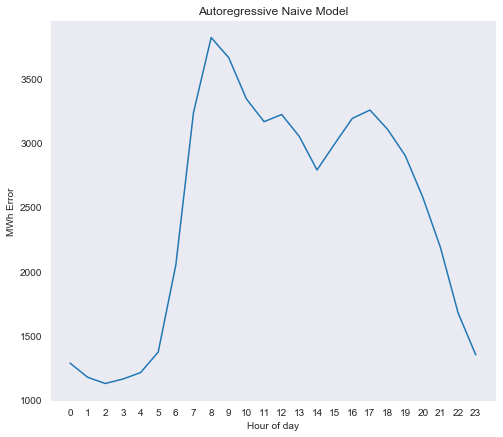

In [39]:
plot_error(errors_naive)

We can see the model does relatively good job predicting from midnight to about 4 am. This makes sense because when considering a typical demand load profile this period is known as the 'base load'. This is the minimum load that grid operators expect to see, and plan to always maintain.

## Moving Average

The moving average forecast uses the moving average from the last t-x steps to predict t. In this example we will investigate moving average of 3, 7, 14 days.

In [45]:
#get the data as X is t-1, and Y is t
X_ma, Y_ma = set_X_Y_features(data, univariate=True)
X_ma.shape, Y_ma.shape

((1066, 24), (1066, 24))

To get an idea what the moving average is doing lets plot the first two months (60 days) of the data along with the moving averages from 3, 7 and 14 days.

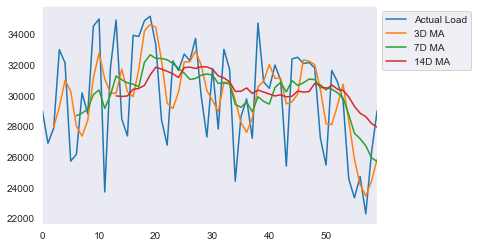

In [75]:
#set interval parmaters
hour= 18
day_start=0
day_end=60

#select data slice
load_range = X_ma.iloc[day_start:day_end,hour]

#plot the original data
load_range.plot(label='Actual Load')

#plot the moving averages
load_range.rolling(3).mean().plot(label='3D MA')
load_range.rolling(7).mean().plot(label='7D MA')
load_range.rolling(14).mean().plot(label='14D MA')

#set the legend location
plt.legend(bbox_to_anchor=(1,1))

We can see how the moving averages 'smooth' out the original data. The shorter the MA window the closer to the original data. The longer the MA window the more it follows the long term trends.

We can now setup a model that uses a moving average to predict t and calcualte the error. 

In [ ]:

X_ma.iloc[:,12].plot()
#X_ma.iloc[12].rolling(3).mean().plot()
#X_ma.iloc[12].rolling(7).mean().plot()
#X_ma.iloc[12].rolling(14).mean().plot()

In [ ]:
#for each hourly timestep construct moving averages form the last x days
def get_moving_averages(X, moving_average=3):
    
    
    
    return None

In [51]:
X_ma = pd.DataFrame(X_ma)

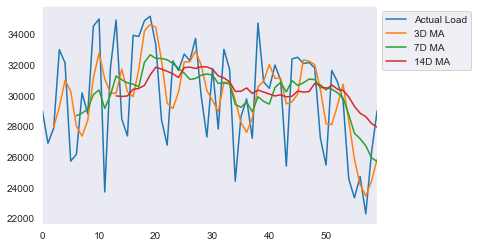

In [74]:
hour= 18
day_start=0
day_end=60

labels = {}

load_range = X_ma.iloc[day_start:day_end,hour]

load_range.plot(label='Actual Load')
load_range.rolling(3).mean().plot(label='3D MA')
load_range.rolling(7).mean().plot(label='7D MA')
load_range.rolling(14).mean().plot(label='14D MA')
plt.legend(bbox_to_anchor=(1,1))

## ARIMA

ARIMA stands for Autoregressive Integrated Moving Average. Compared with the above model it uses a linear combination of past time steps, and moving averages to predict t.

ARIMA takes only a stationary time series. As explored in the ***DATA ANALYSIS*** notebook the load data can be made stationary by ***ANALYSIS RESULTS***

We will use the ARIMA model from statsmodels.api which takes the following arguments:
- p: is the number of lag observations in he model. Lag order.
- d: the number of times raw observations are differenced. Degree of differencing.
- q: the side of the moving average window. The order of moving average.
